<a href="https://colab.research.google.com/github/robgon-art/e-dall-e/blob/main/E_DALL_E_Image_Expander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-DALL-E Image Expander: Create Digital Art with Varying Aspect Ratios**
## How to expand images generated with DALL-E Mini by using VQGAN and CLIP to inpaint the sides

By Robert. A Gonsalves</br>

![image](https://raw.githubusercontent.com/robgon-art/e-dall-e/main/e-dal-e_med.png)

You can see my article on [Medium](https://towardsdatascience.com/e-dall-e-creating-digital-art-with-varying-aspect-ratios-5de260f4713d).

The source code and generated images are released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/).</br>
![CC BYC-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)

In [ ]:
#@title Initialize the System
!nvidia-smi
print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP                 &> /dev/null
 
print("Installing Python Libraries for AI")
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
print("Installing transformers library...")
!pip install transformers   
print("Installing taming.models...")   
!pip install taming.models                           &> /dev/null
 
%reload_ext autoreload
%autoreload                  &> /dev/null
print("Installation finished.")

import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

import torch
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            # K.ColorJitter(hue=0.01, saturation=0.01, p=0.7)
            K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
            )
        
        self.noise_fac = 0.1
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    # print("\n", z_q.shape)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    result = []

    if args.init_weight:
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    filename = f"steps/{i:04}.png"
    imageio.imwrite(filename, np.array(img))
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

!curl -L -o farmland.png -C - 'https://raw.githubusercontent.com/robgon-art/e-dall-e/main/farmland2.png'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


model = load_vqgan_model("/content/vqgan_imagenet_f16_16384.yaml", "/content/vqgan_imagenet_f16_16384.ckpt").to(device)
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
f = 2**(model.decoder.num_resolutions - 1)
!mkdir steps

Aspect ratio: 16:9
Using text prompt: ['a painting of rolling farmland']
Using image prompts: ['farmland.png']
Using seed: 18000786836381011741
Using learning rate: 0.1


0it [00:00, ?it/s]

i: 0, loss: 0.911123, losses: 0.789966, 0.121157


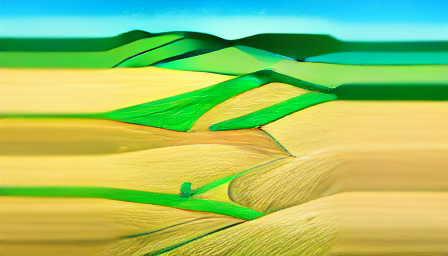

i: 20, loss: 0.878634, losses: 0.76329, 0.115343


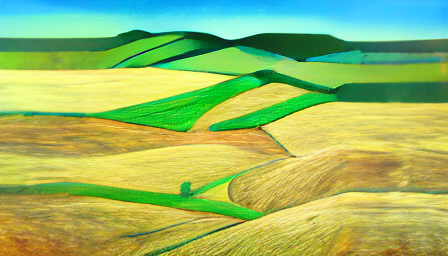

i: 40, loss: 0.87921, losses: 0.762774, 0.116437


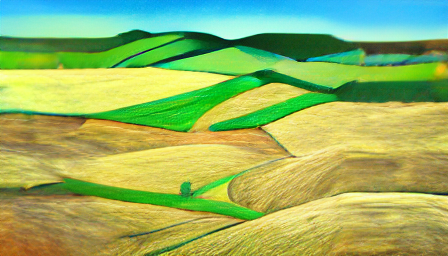

i: 60, loss: 0.867516, losses: 0.757556, 0.10996


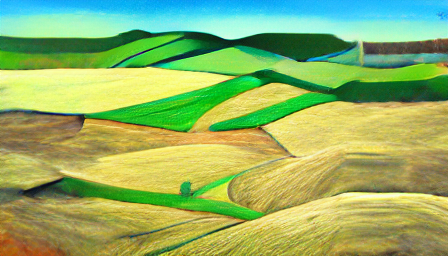

i: 80, loss: 0.865213, losses: 0.751852, 0.113361


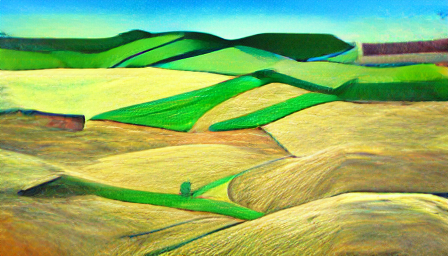

i: 100, loss: 0.861066, losses: 0.74834, 0.112726


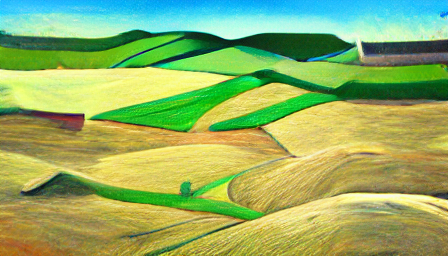

i: 120, loss: 0.868881, losses: 0.754107, 0.114774


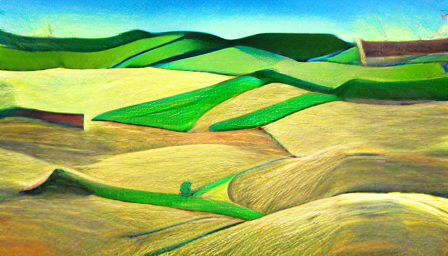

i: 140, loss: 0.864287, losses: 0.752182, 0.112105


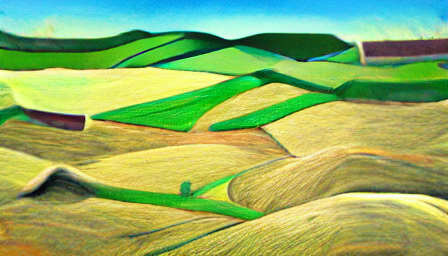

i: 160, loss: 0.858024, losses: 0.746177, 0.111847


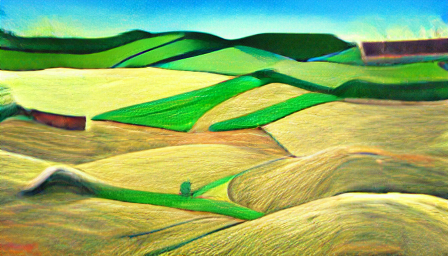

i: 180, loss: 0.868291, losses: 0.75154, 0.116751


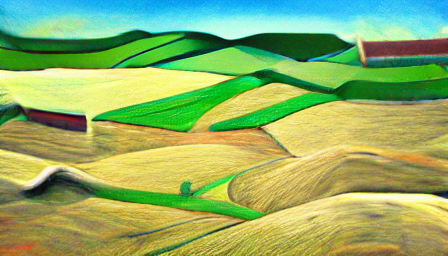

i: 200, loss: 0.866845, losses: 0.752929, 0.113916


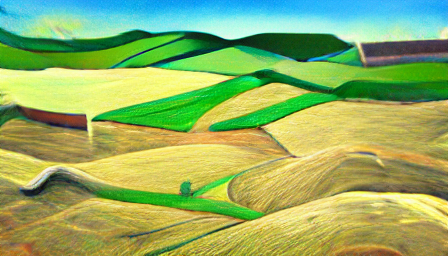

a painting of rolling farmland


In [ ]:
#@title Generate an Image
import argparse
text_prompts = "a painting of rolling farmland" #@param {type:"string"}
aspect_ratio = '16:9' #@param ["2:1 (widest)", "16:9 (wider)", "4:3 (wider)", "1:1 (square)", "3:4 (tall)", "16:9 (taller)", "2:1 (tallest)", "w:h (custom)"] {allow-input: true}
display_frequency =  20#@param {type:"number"}
initial_image = "farmland.png"#@param {type:"string"}
target_images = "farmland.png"#@param {type:"string"}
learning_rate_exp = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
max_iterations = 200#@param {type:"number"}

if len(text_prompts) == 0 and len(target_images) == 0:
  text_prompts = "-"

learning_rate = 10**learning_rate_exp

import re
import shutil
valid_aspect_ratio = True

if ":" not in aspect_ratio:
  valid_aspect_ratio = False
else:
  parts = aspect_ratio.split(":")
  if len(parts) != 2:
    valid_aspect_ratio = False  

  aspect_w = re.sub("[^0-9]", "", parts[0])
  aspect_h = re.sub("[^0-9]", "", parts[1])

  if len(aspect_w) == 0 or len(aspect_h) == 0:
    valid_aspect_ratio = False

if not valid_aspect_ratio:
  print()
  print("Error parsing aspect ratio.")
  print("Please enter two numbers seperated by a ':'.")
  print("Using the default 16:9 aspect ratio for this run.")
else:
  print("Aspect ratio:", aspect_w +':' + aspect_h)

  seed = None
  if initial_image == "None":
      initial_image = None
  if target_images == "None" or not target_images:
      target_images = []
  else:
      target_images = target_images.split("|")
      target_images = [image.strip() for image in target_images]

  prompts = [frase.strip() for frase in text_prompts.split("|")]
  if prompts == ['']:
      prompts = []

  args = argparse.Namespace(
      prompts=prompts,
      image_prompts=target_images,
      noise_prompt_seeds=[],
      noise_prompt_weights=[],
      init_image=initial_image,
      init_weight=0.,
      step_size=learning_rate,
      cutn=64,
      cut_pow=1.,
      display_freq=display_frequency,
      seed=seed,
  )

  if prompts:
      print('Using text prompt:', prompts)
  if target_images:
      print('Using image prompts:', target_images)
  if args.seed is None:
      seed = torch.seed()
  else:
      seed = args.seed
  torch.manual_seed(seed)
  print('Using seed:', seed)

  print('Using learning rate:', round(learning_rate, 5))

  cut_size = perceptor.visual.input_resolution
  e_dim = model.quantize.e_dim
  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
  n_toks = model.quantize.n_e
  z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
  z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

  aspect_target = int(aspect_w) / int(aspect_h)
  # print("aspect_target", aspect_target)

  pil_image = Image.open(initial_image).convert('RGB')
  w_orig, h_orig = pil_image.size

  aspect_source = w_orig/h_orig
  # print("aspect_source", aspect_source)

  toksX_source = w_orig // f
  toksY_source = h_orig // f

  if (aspect_target > aspect_source):
    grow_wide = True
    toksY_target = toksY_source
    h_target = h_source = toksY_target * f
    w_source = round(aspect_source*h_source)
    width_temp = aspect_target * h_target
    toksX_target = int(width_temp // f)
    if (toksX_source + toksX_target) % 2 == 1:
      toksX_target -= 1
    w_target = int(toksX_target * f)
  else:
    grow_wide = False
    toksX_target = toksX_source
    w_target = w_source = toksX_target * f
    h_source = round(w_source/aspect_source)
    height_temp = w_target / aspect_target
    toksY_target = int(height_temp // f)
    if (toksY_source + toksY_target) % 2 == 1:
      toksY_target -= 1
    h_target = int(toksY_target * f)

  if toksX_source == toksX_target and toksY_source == toksY_target:
    print()
    print("Error: Entered aspect ratio:", aspect_source,
          "is too close to the original:", aspect_target)
  elif aspect_target >2:
    print()
    print("Error: aspect ratio is too wide", aspect_target)
  elif aspect_target < 0.5:
    print()
    print("Error: aspect ratio is too tall", aspect_target)
  else:
    pil_image = pil_image.resize((w_source, h_source), Image.BILINEAR)

    # print("toksX_source, toksY_source", toksX_source, toksY_source)
    # print("toksX_target, toksY_target", toksX_target, toksY_target)

    # print("w_source, h_source", w_source, h_source)
    # print("w_target, h_target", w_target, h_target)

    if args.init_image:
        result = Image.new(pil_image.mode, (w_target, h_target))
        if grow_wide:
          pad_x = (w_target-w_source)//2
          result.paste(pil_image, (pad_x, 0))
          sample = 8
          left_side = pil_image.crop((0, 0, sample, h_source))
          left_side = left_side.resize((1, h_source//2), Image.BILINEAR)
          left_side = left_side.resize((pad_x, h_source), Image.BILINEAR)
          result.paste(left_side, (0, 0))
          right_side = pil_image.crop((w_source-sample, 0, w_source, h_source))
          right_side = right_side.resize((1, h_source//2), Image.BILINEAR)
          right_side = right_side.resize((w_source-pad_x, h_source), Image.BILINEAR)
          result.paste(right_side, (w_target-pad_x, 0))
          image_np = np.array(result, dtype=np.float32)
          overlap = 32
          alpha = np.arange(0, 1, 1.0/overlap, dtype=np.float32)
          # print("alpha.shape", alpha.shape)
          alpha = np.tile(alpha, [3, h_target, 1])
          # print("alpha.shape", alpha.shape)
          alpha = alpha.transpose(1, 2, 0)
          # print("alpha.shape", alpha.shape)
          left_np = np.array(left_side.resize((overlap, h_target)), dtype=np.float32)
          right_np = np.array(right_side.resize((overlap, h_target)), dtype=np.float32)
          image_np[:,pad_x:pad_x+overlap,:] = image_np[:,pad_x:pad_x+overlap,:] * alpha \
            + left_np * (1-alpha)
          image_np[:,-pad_x-overlap:-pad_x,:] = image_np[:,-pad_x-overlap:-pad_x,:] * (1- alpha) \
            + right_np * alpha
        else:
          pad_y = (h_target-h_source)//2
          result.paste(pil_image, (0, pad_y))
          sample = 8
          top_side = pil_image.crop((0, 0, w_source, sample))
          top_side = top_side.resize((w_source//2, 1), Image.BILINEAR)
          top_side = top_side.resize((w_source, pad_y), Image.BILINEAR)
          result.paste(top_side, (0, 0))
          bottom_side = pil_image.crop((0, h_source-sample, w_source, h_source))
          bottom_side = bottom_side.resize((w_source//2, 1), Image.BILINEAR)
          bottom_side = bottom_side.resize((w_source, h_source-pad_y), Image.BILINEAR)
          result.paste(bottom_side, (0, h_target-pad_y))
          image_np = np.array(result, dtype=np.float32)
          overlap = 32
          alpha = np.arange(0, 1, 1.0/overlap, dtype=np.float32)
          # print("alpha.shape", alpha.shape)
          alpha = np.tile(alpha, [3, w_target, 1])
          # print("alpha.shape", alpha.shape)
          alpha = alpha.transpose(2, 1, 0)
          # print("alpha.shape", alpha.shape)
          top_np = np.array(top_side.resize((w_target, overlap)), dtype=np.float32)
          bottom_np = np.array(bottom_side.resize((w_target, overlap)), dtype=np.float32)
          image_np[pad_y:pad_y+overlap:,:] = image_np[pad_y:pad_y+overlap,:,:] * alpha \
            + top_np * (1-alpha)
          image_np[-pad_y-overlap:-pad_y,:,:] = image_np[-pad_y-overlap:-pad_y,:,:] * (1- alpha) \
            + bottom_np * alpha

        # print("image_np.shape", image_np.shape)
        # print("image_np.dtype", image_np.dtype)
        pil_image = Image.fromarray(image_np.astype(np.uint8))
        z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
    else:
        one_hot = F.one_hot(torch.randint(n_toks, [toksY_target * toksX_target], device=device), n_toks).float()
        z = one_hot @ model.quantize.embedding.weight
        z = z.view([-1, toksY_target, toksX_target, e_dim]).permute(0, 3, 1, 2)

    z_orig = z.clone()
    z.requires_grad_(True)

    opt = optim.Adam([z], lr=args.step_size)

    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                    std=[0.26862954, 0.26130258, 0.27577711])

    pMs = []

    for prompt in args.prompts:
        txt, weight, stop = parse_prompt(prompt)
        embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
        pMs.append(Prompt(embed, weight, stop).to(device))

    for prompt in args.image_prompts:
        path, weight, stop = parse_prompt(prompt)
        img = resize_image(Image.open(path).convert('RGB'), (w_target, h_target))
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = perceptor.encode_image(normalize(batch)).float()
        pMs.append(Prompt(embed, weight, stop).to(device))

    for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
        gen = torch.Generator().manual_seed(seed)
        embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
        pMs.append(Prompt(embed, weight).to(device))

    c33 = 1.0/3.0
    c66 = 1.0-c33

    i = 0
    try:
      with tqdm() as pbar:
        while True:
          train(i)
          with torch.no_grad():
            if grow_wide:
              w_keep = toksX_target - toksX_source
              lft = w_keep//2
              rgt = toksX_target - lft - 1
              z[:,:,:,lft] = c66*z[:,:,:,lft] + c33*z_orig[:,:,:,lft]
              z[:,:,:,lft+1] = c33*z[:,:,:,lft+1] + c66*z_orig[:,:,:,lft+1]
              z[:,:,:,lft+2:rgt-1] = z_orig[:,:,:,lft+2:rgt-1]
              z[:,:,:,rgt-1] = c66*z_orig[:,:,:,rgt-1] + c33*z[:,:,:,rgt-1]
              z[:,:,:,rgt] = c33*z_orig[:,:,:,rgt] + c66*z[:,:,:,rgt]
            else:
              h_keep = toksY_target - toksY_source
              top = w_keep//2
              bot = toksY_target - top - 1
              z[:,:,top,:] = c66*z[:,:,top,:] + c33*z_orig[:,:,top,:]
              z[:,:,top+1,:] = c33*z[:,:,top+1,:] + c66*z_orig[:,:,top+1,:]
              z[:,:,top+2:bot-1,:] = z_orig[:,:,top+2:bot-1,:]
              z[:,:,bot-1,:] = c66*z_orig[:,:,bot-1,:] + c33*z[:,:,bot-1,:]
              z[:,:,bot,:] = c33*z_orig[:,:,bot,:] + c66*z[:,:,bot,:]

          if i == max_iterations:
              break
          i += 1
          pbar.update()
    except KeyboardInterrupt:
      pass

    src = "/content/steps/" + str(max_iterations-1).zfill(4) + ".png"
    shutil.copyfile(src, "/content/out.png")
    print(text_prompts)